# Housekeeping

First, import the required modules, including NetworkX package:

In [33]:
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)
from adjustText import adjust_text
import json
import numpy as np
from pandas import json_normalize

# Follower network

## Loading the friend/follower relations between pairs of list members from friendships.csv into a Pandas Data Frame. 

In [34]:
in_path = Path("./business", "friendships.csv")
# create the Data Frame
df = pd.read_csv(in_path, sep='\t')
print("The number of Twitter relations: %d" % len(df))
# display a few rows
df.head(len(df))

The number of Twitter relations: 308


,FRIEND,FOLLOWER
0,apbusiness,bbcbusiness
1,apbusiness,business
2,apbusiness,businessinsider
3,apbusiness,bw
4,apbusiness,cnnbusiness
...,...,...
303,yahoofinanceuk,bbcbusiness
304,yahoofinanceuk,ft
305,yahoofinanceuk,ftfinancenews
306,yahoofinanceuk,telebusiness


## Creating a Directed Network

We will now construct a *directed unweighted network* such that:

- There is a node for each Twitter user.
- There is a directed edge between each unique user and follower pair.

### First, get the set of all users:

In [35]:
# get set of all users
friends = set(df["FRIEND"].unique())
followers = set(df["FOLLOWER"].unique())
users = friends.union(followers)

# just print to see how many and what users we have
for index, element in enumerate(users, start=1):
    print(f"{index}: {element}")

1: apbusiness
2: yahoofinanceuk
3: harvardbiz
4: foxbusiness
5: cnnbusiness
6: telebusiness
7: fastcompany
8: nbcnewsbusiness
9: bbcworldbiz
10: ft
11: indobusiness
12: yahoofinance
13: businessdesk
14: business
15: reutersmoney
16: irishtimesbiz
17: usatodaymoney
18: entrepreneur
19: reutersbiz
20: wsjbusiness
21: bw
22: marketwatch
23: businessinsider
24: wsjecon
25: thestreet
26: financialtimes
27: bbcbusiness
28: nasdaq
29: nytimesbusiness
30: markets
31: wsj
32: forbes
33: ftfinancenews


### Create a directed network, with a node for each user:

In [36]:
# here a DiGraph indicates a directed network
g = nx.DiGraph()
nodes = sorted(list(users))
for node in nodes:
    # we add the city name as an attribute
    g.add_node(node)

### Create a directed edge between each unique friend and follower pair, based on the Twitter friendships.csv file

In [37]:
for i, row in df.iterrows():
    node1 = row["FRIEND"]
    node2 = row["FOLLOWER"]
    # ignore self-loops, in case they exist
    if node1 == node2:
        continue
    g.add_edge(node1, node2)

## Characterising the network using statistics

### We check **the basic characteristics** of our network:
- number of nodes and edges
- density
- number of strongly connected components

In [38]:
print("Network has %d nodes and %d edges" % (g.number_of_nodes(), g.number_of_edges()))
print("Density = %.4f" % nx.density(g))
print("Number of strongly connected components = %.0f" % nx.number_strongly_connected_components(g))

Network has 33 nodes and 308 edges
Density = 0.2917
Number of strongly connected components = 5


### We measure **the centrality** of our network
- number of connections of each note (the simplest measure of centrality)

In [39]:
# We can use networkX to produce a dictionary of centrality values, where the keys are the nodes.
deg = dict(nx.degree(g))
deg

{'apbusiness': 26,
 'bbcbusiness': 13,
 'bbcworldbiz': 1,
 'business': 31,
 'businessdesk': 26,
 'businessinsider': 20,
 'bw': 19,
 'cnnbusiness': 23,
 'entrepreneur': 8,
 'fastcompany': 17,
 'financialtimes': 31,
 'forbes': 23,
 'foxbusiness': 16,
 'ft': 36,
 'ftfinancenews': 11,
 'harvardbiz': 13,
 'indobusiness': 2,
 'irishtimesbiz': 7,
 'markets': 7,
 'marketwatch': 14,
 'nasdaq': 38,
 'nbcnewsbusiness': 30,
 'nytimesbusiness': 27,
 'reutersbiz': 17,
 'reutersmoney': 17,
 'telebusiness': 23,
 'thestreet': 14,
 'usatodaymoney': 34,
 'wsj': 22,
 'wsjbusiness': 14,
 'wsjecon': 13,
 'yahoofinance': 16,
 'yahoofinanceuk': 7}

We identify users with **the largest amount** of connections

In [40]:
# create Pandas series
sdeg = pd.Series(deg).sort_values(ascending=False)
sdeg
# create Pandas Data Frame from the series, along with the node city attributes
df = pd.DataFrame({"Degree":sdeg})
df = df.sort_values(by="Degree", ascending=False)
# sort in descending order and get top values
df.sort_values(by="Degree", ascending=False).head(10)

,Degree
nasdaq,38
ft,36
usatodaymoney,34
financialtimes,31
business,31
nbcnewsbusiness,30
nytimesbusiness,27
apbusiness,26
businessdesk,26
telebusiness,23


We identify users with **the smallest amount** of connections

In [41]:
df.sort_values(by="Degree", ascending=True).head(10)

,Degree
bbcworldbiz,1
indobusiness,2
irishtimesbiz,7
markets,7
yahoofinanceuk,7
entrepreneur,8
ftfinancenews,11
wsjecon,13
harvardbiz,13
bbcbusiness,13


**Distribution** of the degree of the score

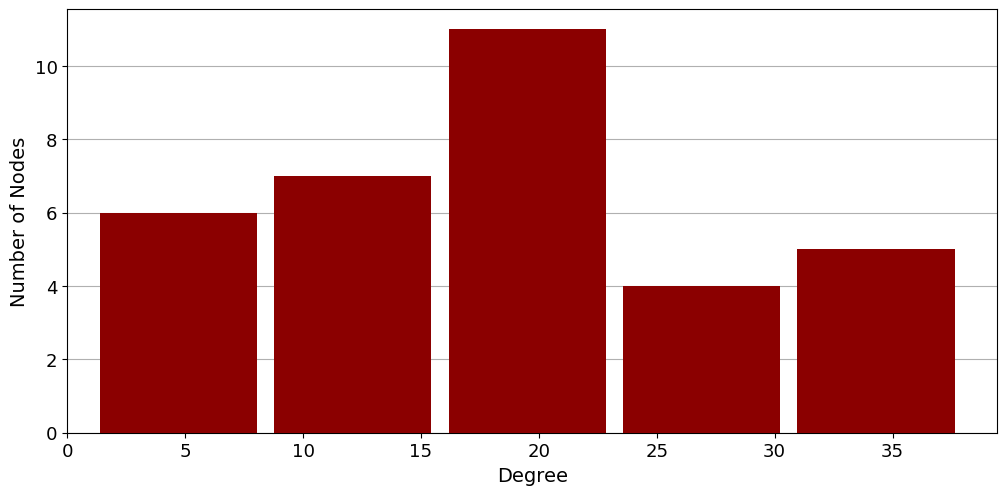

In [42]:
# produce a histogram of the values
ax = df["Degree"].plot(kind="hist", figsize=(12, 5.5), fontsize=13, legend=None, color="darkred", 
    bins=5, zorder=3, rwidth=0.9)
ax.yaxis.grid()
ax.set_xlim(0)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);

### We measure **the in-degree and out-degree centrality** of our network
- In-degree: the number of followers a user has.
- Out-degree: the number of accounts a user follows.

In [43]:
# calculate out-degree and in-degree scores
out_degrees = dict(g.out_degree())
in_degrees = dict(g.in_degree())
# add a column to our Data Frame
df["Out-Degree"] = pd.Series(out_degrees)
df["In-Degree"] = pd.Series(in_degrees)
# see a part of the data frame
df.sort_values(by="Degree", ascending=False).head(10)

,Degree,Out-Degree,In-Degree
nasdaq,38,26,12
ft,36,19,17
usatodaymoney,34,22,12
financialtimes,31,18,13
business,31,14,17
nbcnewsbusiness,30,21,9
nytimesbusiness,27,12,15
apbusiness,26,23,3
businessdesk,26,21,5
telebusiness,23,20,3


Represent graphically in-degree and out-degree scores for each node, which shows that in-degree and out-degree are very different for various users.

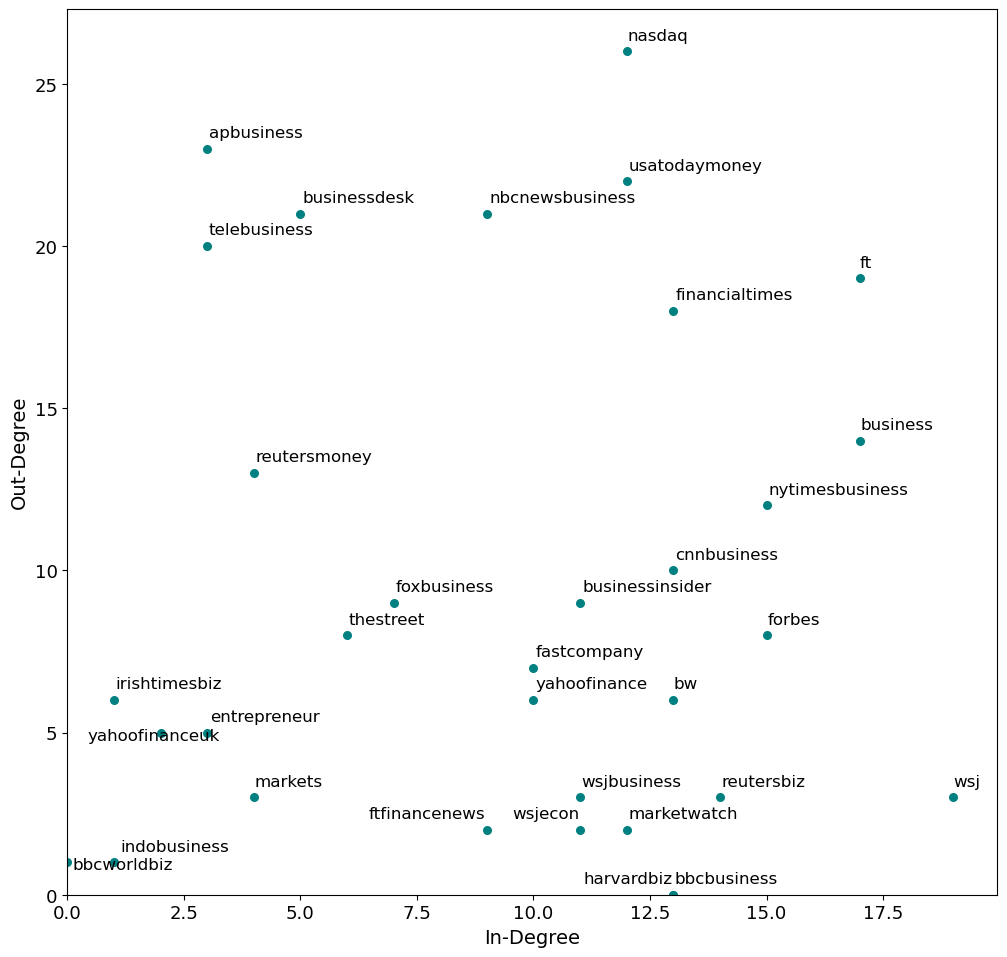

In [55]:
# produce the scatter plot
ax = df.plot(kind="scatter", x="In-Degree", y="Out-Degree", figsize=(12,11.5), 
    fontsize=13, color="teal", s=30)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel("In-Degree", fontsize=14)
ax.set_ylabel("Out-Degree", fontsize=14);

texts = []

# Loop through the DataFrame and add data labels
for index, row in df.iterrows():
    label = index  # or any other label you want to use from the DataFrame
    text = ax.annotate(label, (row["In-Degree"], row["Out-Degree"]),
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=12)
    texts.append(text)    

# Adjust the labels to prevent overlapping
adjust_text(texts)

plt.savefig('output_image1.png', dpi=300, bbox_inches='tight')


## Visualising the network

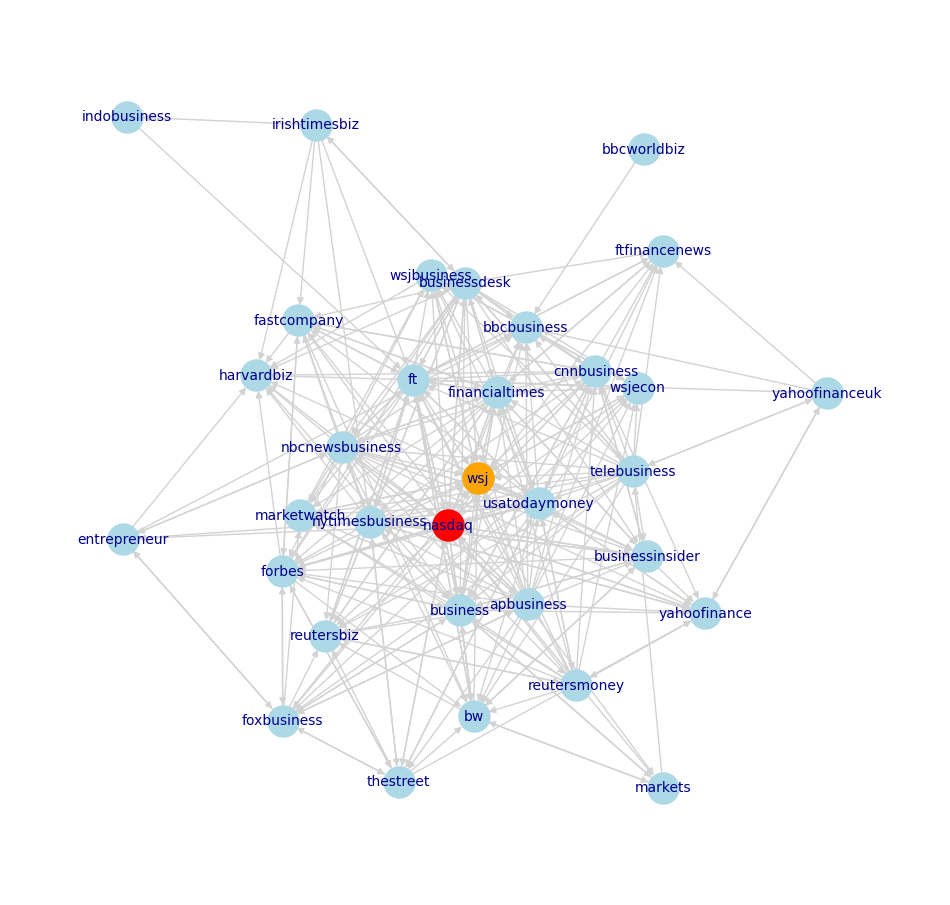

In [53]:
plt.figure(figsize=(12,11.5))
plt.margins(0.1, 0.1)
pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos=pos, with_labels=True, node_color='lightblue', edge_color='lightgrey', node_size=500, font_color='darkblue', font_size=10)
# add the ego node in a different colour
nx.draw_networkx_nodes(g, pos, nodelist=['nasdaq'], node_size=500, node_color="red");
nx.draw_networkx_nodes(g, pos, nodelist=['wsj'], node_size=500, node_color="orange");

plt.savefig('output_image.png', dpi=300, bbox_inches='tight')


# Retweet network

## Loading information on Twitter users needed for retweet and reply networks

In [46]:
in_path2 = Path("./business", "list_members.jsonl")
# create the Data Frame
df2 = pd.read_json(in_path2, lines=True)
print("Read %d members" % len(df2))

# Select relevant columns from the dataframe
selected_columns = ['id', 'screen_name']
df2_selected = df2[selected_columns] 

# Transform the 'Name' column to lowercase
df2_selected['screen_name'] = df2_selected['screen_name'].str.lower()

# Sort the dataframe to see the names alphabetically
df2_selected_modi_sorted = df2_selected.sort_values(by='screen_name')

# Display a framgment of relevant dataframe
df2_selected_modi_sorted.head(len(df2))


Read 33 members


/tmp/ipykernel_68847/2851683304.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_selected['screen_name'] = df2_selected['screen_name'].str.lower()


,id,screen_name
0,3066084185,apbusiness
32,621523,bbcbusiness
1,2252205206,bbcworldbiz
8,34713362,business
10,25070893,businessdesk
12,20562637,businessinsider
6,67358777,bw
20,16184358,cnnbusiness
15,19407053,entrepreneur
29,2735591,fastcompany


## Create a dataframe of **retweets** based on tweets.jsonl. 

In [47]:
# Replace 'your_file.jsonl' with the path to your JSONL file
file_path = Path("./business", "tweets.jsonl")
field_name = 'retweeted_status'

json_objects = []

with open(file_path, 'r') as file:
    for line in file:
        json_object = json.loads(line)
        # read only retweets (i.e. in_reply_to_screen_name with non-missing values)
        if not pd.isna(json_object.get(field_name)):
            json_objects.append(json_object)

# Create a pandas DataFrame from the list of JSON objects
df3 = json_normalize(json_objects)

# Select relevant columns from the dataframe
selected_columns = ['user.id', 'retweeted_status.user.id']
df3_selected = df3[selected_columns] 

# Report the size of retweet dataframe and show part of it
print("The number of retweets: %d" % len(df3_selected))

# Replace the user.id by the name by merging the information
df3_merged = df3_selected.merge(df2_selected_modi_sorted, left_on='user.id', right_on='id')
selected_columns = ['screen_name', 'retweeted_status.user.id']
df3_merged = df3_merged[selected_columns] 
print("The number of retweets after identifying user.id: %d" % len(df3_merged))

# Replace the retweeted_status.user.id by the name by merging the information
df3_merged2 = df3_merged.merge(df2_selected_modi_sorted, left_on='retweeted_status.user.id', right_on='id')
selected_columns = ['screen_name_x', 'screen_name_y']
df3_merged2 = df3_merged2[selected_columns] 
print("The number of retweets after identifying retweeted_status.user.id: %d" % len(df3_merged2))

# Make sure we remove self-retweets if there are any
df3_merged2_unique = df3_merged2[df3_merged2['screen_name_x'] != df3_merged2['screen_name_y']]
print("The number of retweets after identifying retweeted_status.user.id that are not self-retweets: %d" % len(df3_merged2_unique))

# Displaying part of the dataframe
# screen_name_x is an author of a tweet
# screen_name_y is a user who retweeted the tweet
df3_merged2_unique.head()



The number of retweets: 3569
The number of retweets after identifying user.id: 3569
The number of retweets after identifying retweeted_status.user.id: 439
The number of retweets after identifying retweeted_status.user.id that are not self-retweets: 434


,screen_name_x,screen_name_y
0,reutersmoney,reutersbiz
1,reutersmoney,reutersbiz
2,reutersmoney,reutersbiz
3,reutersmoney,reutersbiz
4,reutersmoney,reutersbiz


## Creating a Directed Weighted Network

In [48]:
# here a DiGraph indicates a directed weighted network
g2 = nx.DiGraph()
nodes = sorted(list(users))
for node in nodes:
    # we add the user name as an attribute
    g2.add_node(node)

# count the retweet frequencies between each pair of users
from collections import Counter
freqs = Counter()
# make sure to apply this to the filtered Data Frame
for i, row in df3_merged2_unique.iterrows():
    node1 = row["screen_name_x"]
    node2 = row["screen_name_y"]
    # ignore self-loops, in case they exist
    if node1 == node2:
        continue
    pair = (node1,node2)
    freqs[pair] += 1

# Now we create a directed weighted edge between each unique author and retweeter pair:
for pair in freqs:
    g2.add_edge(pair[0], pair[1], weight=freqs[pair])
print("Created network with %d nodes and %d edges" % (g2.number_of_nodes(), g2.number_of_edges() ))

# Based on the weights on the edges in this network, we can identify the most frequent flight routes in this flight network.
rows = []
for node1, node2, data in g2.edges(data=True):
    # get the city names from the node attributes
    origin = g.nodes[node1]
    destination = g.nodes[node2]
    rows.append({"Tweeter":origin, "Re-tweeter ":destination, "Weight":data["weight"]})
# create the Data Frame and sort in descending order by weight
df_edges = pd.DataFrame(rows).sort_values(by="Weight", ascending=False)
df_edges.head(20)

Created network with 33 nodes and 11 edges


,Tweeter,Re-tweeter,Weight
7,{},{},358
5,{},{},40
4,{},{},22
9,{},{},5
2,{},{},3
0,{},{},1
1,{},{},1
3,{},{},1
6,{},{},1
8,{},{},1


## Weighted Centrality Measures

In [64]:
deg = dict(nx.degree(g2))
deg
sdeg = pd.Series(deg).sort_values(ascending=False)
sdeg
# create Pandas Data Frame from the series, along with the node city attributes
df = pd.DataFrame({"Degree":sdeg})
df.head()

,Degree
business,4
bw,4
markets,4
wsj,2
yahoofinanceuk,1


In [66]:
# calculate weighted out-degree
wout_degrees = dict(g2.out_degree(weight="weight"))
df["W-Out-Degree"] = pd.Series(wout_degrees)
# sort in descending order and get top values
df.sort_values(by="W-Out-Degree", ascending=False).head(10)

,Degree,W-Out-Degree
reutersmoney,1,358
markets,4,62
wsjecon,1,5
bw,4,4
business,4,2
yahoofinanceuk,1,1
wsjbusiness,1,1
nasdaq,1,1
businessdesk,0,0
businessinsider,0,0


In [67]:
# calculate weighted in-degree
win_degrees = dict(g2.in_degree(weight="weight"))
# add a column to our Data Frame
df["W-In-Degree"] = pd.Series(win_degrees)
# sort in descending order and get top values
df.sort_values(by="W-In-Degree", ascending=False).head(10)

,Degree,W-Out-Degree,W-In-Degree
reutersbiz,1,0,358
business,4,2,43
bw,4,4,23
wsj,2,0,6
markets,4,62,2
forbes,1,0,1
yahoofinance,1,0,1
businessdesk,0,0,0
businessinsider,0,0,0
cnnbusiness,0,0,0


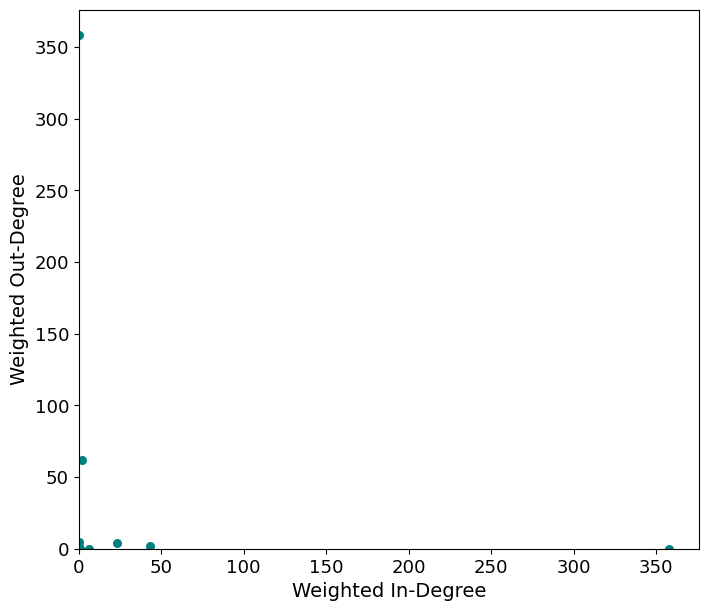

In [68]:
# produce a scatter plot
ax = df.plot(kind="scatter", x="W-In-Degree", y="W-Out-Degree", figsize=(8, 7), 
    fontsize=13, color="teal", s=30)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel("Weighted In-Degree", fontsize=14)
ax.set_ylabel("Weighted Out-Degree", fontsize=14);

# Reply network

#### Create a dataframe of **reply** based on tweets.jsonl. 

In [50]:
# Replace 'your_file.jsonl' with the path to your JSONL file
file_path = Path("./business", "tweets.jsonl")
field_name = 'in_reply_to_screen_name'

json_objects = []

with open(file_path, 'r') as file:
    for line in file:
        json_object = json.loads(line)
        # read only reply (i.e. in_reply_to_screen_name with non-missing values)
        if not pd.isna(json_object.get(field_name)):
            json_objects.append(json_object)

# Create a pandas DataFrame from the list of JSON objects
df4 = json_normalize(json_objects)

# Select relevant columns from the dataframe
selected_columns = ['user.id', 'in_reply_to_screen_name']
df4_selected = df4[selected_columns] 

# Report the size of reply dataframe
print("The number of replies: %d" % len(df4_selected))

# Replace the user id by the name by merging the information
df4_merged = df4_selected.merge(df2_selected_modi_sorted, left_on='user.id', right_on='id')
df4_merged['in_reply_to_screen_name'] = df4_merged['in_reply_to_screen_name'].str.lower()

# Since there are plenty of self-replies eliminate them
df4_merged_unique = df4_merged[df4_merged['in_reply_to_screen_name'] != df4_merged['screen_name']]
selected_columns = ['screen_name', 'in_reply_to_screen_name']
print("The number of replies that are not self-replies: %d" % len(df4_merged_unique))

# Select relevant columns
# screen_name is an author of a tweet reply
# in_reply_to_screen_name is a user to whom a reply is addressed 
df4_merged_unique = df4_merged_unique[selected_columns] 
df4_merged_unique.head(len(df4_merged_unique))

The number of replies: 384
The number of replies that are not self-replies: 98


,screen_name,in_reply_to_screen_name
5,thestreet,twitterspaces
11,thestreet,wolf_financial
18,financialtimes,goldstone_tony
21,financialtimes,theblackmnts
26,financialtimes,lindabrooke6
...,...,...
371,usatodaymoney,aldiusa
372,usatodaymoney,walmart
373,usatodaymoney,walmart
374,indobusiness,lagarde
